## Visualise school traffic

In [26]:
import os
from os.path import join
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
import transport_flow_and_disruption_functions as tfdf

plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}

COUNTRY = 'DMA'
caribbean_epsg = 32620

CONFIG = load_config(os.path.join("..", "..", ".."))
datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
schools = gpd.read_file(join(datadir, 'infrastructure', 'social', 'education.gpkg'))
schools = schools[schools['iso_code'] == COUNTRY]

school_paths = pd.read_parquet(join(resultsdir, f"transport/path and flux data/schools/{COUNTRY}_schools_pathdata_time_m_60.parquet"))

loading config file from ../../...
Number of nodes: 7,613
Number of edges: 8,336


In [27]:
from shapely.geometry import MultiLineString

def get_multilinestring(path, edge_geoms):
    linestrings = [edge_geoms.loc[edge].geometry for edge in path]
    return MultiLineString(linestrings)


edge_geoms = roads[['edge_id', 'geometry']].set_index('edge_id')
school_paths['geometry'] = school_paths['edge_path'].apply(lambda path: get_multilinestring(path, edge_geoms))
school_paths = gpd.GeoDataFrame(school_paths, geometry='geometry').set_crs(caribbean_epsg)
school_paths = school_paths.sort_values(by='flux', ascending=True)

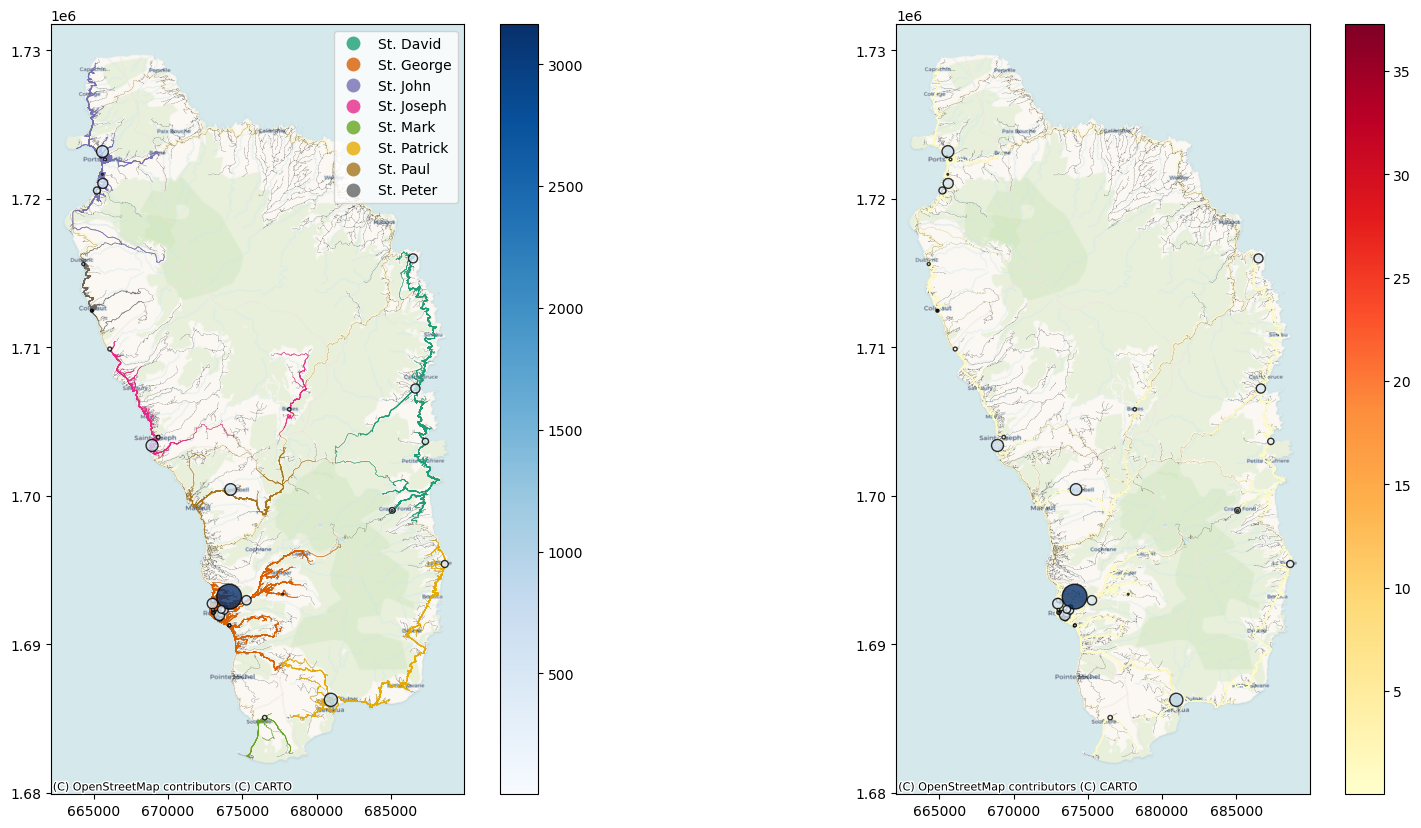

In [28]:
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_buildings(buildings_gdf, col: str, scale=1, **kwargs):
    buildings_gdf.set_geometry(buildings_gdf.centroid).plot(col, markersize=buildings_gdf[col] * scale,
                                          cmap='Blues', alpha=.8,
                                          edgecolor='k',
                                          #norm=colors.LogNorm(vmin, vmax),
                                          **kwargs)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

ax = axs[0]
roads.plot(color='black', linewidth=.2, alpha=.8, linestyle='--', ax=ax, zorder=1)
school_paths.plot('school_district', linewidth=.5, alpha=.8, categorical=True, ax=ax, cmap="Dark2", zorder=2, legend=True)
# schools.set_geometry(schools.centroid).plot(color='k', alpha=.6, ax=ax, marker="^", zorder=3)
plot_buildings(schools, 'assigned_students', scale=.1, legend=True, ax=ax, zorder=3)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=school_paths.crs, zoom=12)

ax = axs[1]
roads.plot(color='black', linewidth=.2, alpha=.8, linestyle='--', ax=ax, zorder=1)
school_paths.plot('flux', linewidth=.5, alpha=.5,
#                   norm=colors.LogNorm(school_paths['flux'].min(), school_paths['flux'].max()),
                  vmin=school_paths['flux'].min(), vmax=school_paths['flux'].max(),
                  ax=ax, cmap="YlOrRd", zorder=2, legend=True)
plot_buildings(schools, 'assigned_students', scale=.1, ax=ax, zorder=3, legend=False)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=school_paths.crs, zoom=12)

fig.savefig(os.path.join(figdir, f"{COUNTRY}_school_routes.png"), **plot_kwargs)
! say done

## Visualise school traffic disruption

In [146]:
import os
from os.path import join
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
import transport_flow_and_disruption_functions as tfdf

plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}

COUNTRY = 'LCA'
caribbean_epsg = 32620

CONFIG = load_config(os.path.join("..", "..", ".."))
datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
schools = gpd.read_file(join(datadir, 'infrastructure', 'social', 'education.gpkg'))
schools = schools[schools['iso_code'] == COUNTRY]

disruption_df = pd.read_parquet(join(resultsdir, "transport/disruption results/lca_schools_roads_edges_sector_damages_with_rerouting.parquet"))
disruption_df = disruption_df[['hazard', 'rcp', 'rp', 'trips_lost_mean', '%trips_lost_mean', 'time_m_delta_mean',
               '%time_m_delta_mean', '%time_m_delta_amax', 'rerouting_loss_person_time_m_mean', '%time_m_delta_total_mean']]
              

loading config file from ../../...
Number of nodes: 8,275
Number of edges: 9,263


array([[<Axes: title={'center': 'rp'}>,
        <Axes: title={'center': 'trips_lost_mean'}>,
        <Axes: title={'center': '%trips_lost_mean'}>],
       [<Axes: title={'center': 'time_m_delta_mean'}>,
        <Axes: title={'center': '%time_m_delta_mean'}>,
        <Axes: title={'center': '%time_m_delta_amax'}>],
       [<Axes: title={'center': 'rerouting_loss_person_time_m_mean'}>,
        <Axes: title={'center': '%time_m_delta_total_mean'}>, <Axes: >]],
      dtype=object)

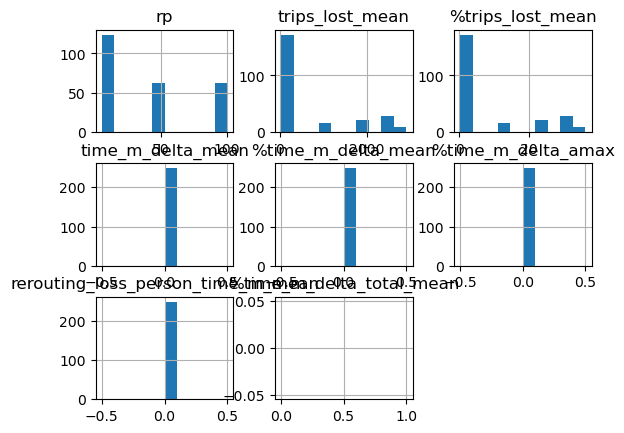

In [148]:
disruption_df.hist()